In [1]:
import pandas as pd
import numpy as np

numerical = pd.read_csv('./files_for_lab/numerical.csv')
categorical = pd.read_csv('./files_for_lab/categorical.csv')
targets = pd.read_csv('./files_for_lab/target.csv')
data = pd.concat([numerical, categorical, targets], axis = 1)

In [2]:
category_1 = data[data['TARGET_B']==1].sample(len(data[data['TARGET_B']==0]), replace=True)
print(category_1.shape)

category_0 = data[data['TARGET_B'] == 0 ]
data = pd.concat([category_0, category_1], axis = 0)
data = data.dropna()
data = data.sample(frac =1) #randomize the rows
data = data.reset_index(drop=True)
print(data.shape)

(90569, 339)
(181138, 339)


In [3]:
y = data['TARGET_B']
X = data.drop(['TARGET_B'], axis = 1)

numericalX = X.select_dtypes(np.number)
categoricalX = X.select_dtypes(np.object)

from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(drop='first').fit(categoricalX)
encoded_categorical = encoder.transform(categoricalX).toarray()
encoded_categorical = pd.DataFrame(encoded_categorical)
X = pd.concat([numericalX, encoded_categorical], axis = 1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [4]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

y_train_regression = X_train['TARGET_D']
y_test_regression = X_test['TARGET_D']

X_train = X_train.drop(['TARGET_D'], axis = 1)
X_test = X_test.drop(['TARGET_D'], axis = 1)

In [5]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=5,
                             min_samples_split=20,
                             min_samples_leaf =20)
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.6155682837623352
0.6112399249199514


In [6]:
# # Runs for too long...

# from sklearn.model_selection import cross_val_score

# clf = RandomForestClassifier(max_depth=5,
#                              min_samples_split=20,
#                              min_samples_leaf =20)
# cross_val_scores = cross_val_score(clf, X_train, y_train, cv=10)
# print(np.mean(cross_val_scores))

In [7]:
from sklearn.metrics import confusion_matrix

y_pred = clf.predict(X_test)
confusion_matrix(y_test, y_pred)

# True positive | False positive
# False negative | True negative

array([[10830,  7286],
       [ 6798, 11314]])

Discuss the output and its impact in the bussiness scenario. Is the cost of a false positive equals to the cost of the false negative? How would you change your algorithm or data in order to maximize the return of the bussiness?

We got a model that shows a stable score of approx. 0.61, similar to the downscaling one.
The false negative's cost is much more adverse in this situation - these are people who will not be targeted with the fundraising campaign and then are likely not to contribute.
Given the mean donation amount of 13 USD, a total of approx. 7k false negatives will translate to a 90k USD loss.
On the flip side, directing the false positives (people who will not donate despite targetted campaign) will only cost approx. 0.6 YSD x 7k, or 4.2k USD in total.

To minimize the losses, we should aim to reduce the number of false negatives. 
We should try out different classification models (there are 29), see below, combined with imbalance treatments (incl. SMOTE) to finds out a model that shows the best results.

In [8]:
# from lazypredict.Supervised import LazyClassifier

# clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
# models,predictions = clf.fit(X_train, X_test, y_train, y_test)

# print(models)

In [82]:
X_test.reset_index(drop=True, inplace=True)
y_test_regression.reset_index(drop=True, inplace=True)
data = pd.DataFrame([])
data = pd.concat([X_test,pd.Series(y_pred)], axis = 1)
data.columns = [*data.columns[:-1], 'predicted_donor']
data = pd.concat([data,y_test_regression], axis = 1)
data = data.rename(columns={'TARGET_D': 'actual_donation'})

In [10]:
# ---- Lab 2 Starts here

In [24]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

# y_train_regression - to be used here

In [28]:
# Building regression model

from sklearn.tree import DecisionTreeRegressor

regr = DecisionTreeRegressor(max_depth=15)
regr.fit(X_train, y_train_regression)

print("test data accuracy was: ",regr.score(X_test, y_test_regression))
print("train data accuracy was: ",regr.score(X_train, y_train_regression))


test data accuracy was:  0.5733995535206327
train data accuracy was:  0.6678473995228519


In [12]:
# Treat with RFE first, see if anything improves

from sklearn.feature_selection import RFE
from sklearn import linear_model
lm = linear_model.LinearRegression()
rfe = RFE(lm, n_features_to_select=20, verbose=False)
rfe.fit(X_train_scaled, y)
df = pd.DataFrame(data = rfe.ranking_, columns=['Rank'])
df['Column_name'] = pd.DataFrame(X_train).columns
df[df['Rank']==1]
X_train_trimmed = X_train[list(df['Column_name'][df['Rank']==1])]
X_test_trimmed = X_test[[list(df['Column_name'][df['Rank']==1])]]
X_test_trimmed = X_test[list(df['Column_name'][df['Rank']==1])]

RFE(estimator=LinearRegression(), n_features_to_select=20, verbose=False)

In [33]:
regr = DecisionTreeRegressor(max_depth=15)
regr.fit(X_train_trimmed, y_train_regression)

print("test data accuracy was: ",regr.score(X_test_trimmed, y_test_regression))
print("train data accuracy was: ",regr.score(X_train_trimmed, y_train_regression))

# Marginally better

test data accuracy was:  0.6010641249897537
train data accuracy was:  0.6828662370318148


100%|██████████| 37/37 [00:41<00:00,  1.13s/it]


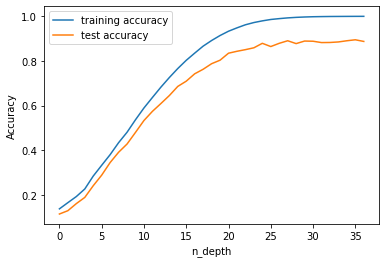

In [40]:
from tqdm import tqdm
import time

max_depth = range(3,40)
test = []
train = []

for depth in tqdm(max_depth):
    model = DecisionTreeRegressor(max_depth=depth)
    model.fit(X_train_trimmed, y_train_regression)
    test.append(model.score(X_test_trimmed,y_test_regression))
    train.append(model.score(X_train_trimmed,y_train_regression))
    
import matplotlib.pyplot as plt
plt.plot( train, label="training accuracy")
plt.plot( test, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_depth")
plt.legend()
plt.show()

# choosing depth as 26

In [91]:
regr = DecisionTreeRegressor(max_depth=26)
regr.fit(X_train_trimmed, y_train_regression)

print("test data accuracy was: ",regr.score(X_test_trimmed, y_test_regression))
print("train data accuracy was: ",regr.score(X_train_trimmed, y_train_regression))

# 0.86 on test, good enough

test data accuracy was:  0.8537026703339546
train data accuracy was:  0.971525817804822


In [83]:
# Applyin this model to what the classification has returned

data = data[data['predicted_donor'] == 1]
data

,TCODE,AGE,INCOME,WEALTH1,HIT,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,...,16,17,18,19,20,21,22,23,predicted_donor,actual_donation
1,2,70.0,2,7,1,0,15,20,52,2,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,11.0
2,1002,77.0,5,6,11,0,64,6,87,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0
4,2,56.0,5,7,6,3,26,36,51,10,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,10.0
5,0,70.0,1,3,1,0,40,8,81,11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0
6,0,82.0,1,2,1,0,31,17,47,11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36218,2,83.0,4,6,0,0,34,33,40,4,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0.0
36219,2,92.0,4,6,1,0,44,23,57,7,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1,10.0
36220,28,53.0,2,3,23,0,31,20,27,15,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,0.0
36221,0,80.0,2,1,7,0,27,25,30,9,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1,9.0


In [88]:
cols = list(df['Column_name'][df['Rank']==1])
cols.append('actual_donation')

data = data[cols]
y_verification = data['actual_donation']
X = data.drop('actual_donation', axis = 1)

,POP90C1,POP90C2,POP90C3,ETH1,DW3,DW5,ETHC1,ETHC2,HUPA1,HUPA2,...,MC2,TPE3,TPE4,TPE5,TPE6,RAMNTALL,NGIFTALL,LASTGIFT,AVGGIFT,actual_donation
1,99,0,0,98,3,28,14,64,12,19,...,38,0,0,0,0,224.00,19,5.0,11.789474,11.0
2,99,0,0,99,1,11,0,8,8,4,...,55,0,0,0,0,103.00,14,10.0,7.357143,0.0
4,99,0,0,77,4,25,16,49,26,3,...,51,0,0,0,0,111.00,13,11.0,8.538462,10.0
5,99,0,0,97,0,76,6,26,1,75,...,59,1,1,0,0,66.00,11,9.0,6.000000,0.0
6,99,0,0,84,0,0,16,47,0,0,...,63,0,0,0,0,113.00,14,12.0,8.071429,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36218,99,0,0,91,8,0,17,49,8,0,...,51,1,1,0,0,319.00,33,14.0,9.666667,0.0
36219,99,0,0,97,4,1,19,60,5,0,...,72,0,0,0,0,160.00,14,17.0,11.428571,10.0
36220,0,99,0,99,16,9,25,58,25,0,...,52,0,0,0,0,84.75,29,10.0,2.922414,0.0
36221,0,0,99,99,0,6,26,54,3,2,...,74,0,0,0,0,56.00,7,11.0,8.000000,9.0


In [95]:
regr.predict(X).sum() # 145k predicted donation
y_verification.sum() # 139k actual donation

# Not too bad, the results are dramatically better than the naive scenario.

138940.91999999998